# Homework 1: Finding Similar Items: Textually Similar Documents

This homework has been done by Group 9, the students are Anna Kovács and Alex Orlandi.

The task is to implement the stages of finding textually similar documents based on Jaccard similarity using the shingling, minhashing, and locality-sensitive hashing (LSH) techniques and corresponding algorithms. We wrote the code on this Google Colab.


## Initialization

In this section we set up the environment for performing distributed data processing with PySpark and data manipulation with NumPy, Pandas and Matplotlib. We set up Spark to run locally within Google Colab.

In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

from google.colab import files
from pyspark import SparkContext, SparkConf # Spark's core classes

!pip install findspark
import findspark # To set up the environment for pyspark

In [2]:
findspark.init() # findspark's initialization

conf = SparkConf().setAppName("Homework_1_similar_documents").setMaster("local[*]") # Local mode
sc = SparkContext(conf=conf) # Entry point for Spark's functionalities

## Dataset

We decide to use a dataset generated by us: it contains 10 rows with job descriptions. We perform some exploratory data analysis to give some information about the dataset. Each row will then be extracted and put into a dictionary, with a corresponding unique ID.

The dataset is available here:
https://drive.google.com/file/d/1uplf6Q1qS2eByzwMdMuJ9qZDUhp1BDc1/view?usp=share_link

In [3]:
uploaded = files.upload()
df = pd.read_csv("Personalized_dataset_homework1.csv", delimiter=";")

Saving Personalized_dataset_homework1.csv to Personalized_dataset_homework1.csv


In [4]:
df.head()

,Job_ID,Description
0,0,"As a Data Scientist at Google, you will be joi..."
1,1,"As a Junior Marketing Analyst at Mango, you wi..."
2,2,"As a Junior Data Engineer at Apple, you’ll joi..."
3,3,"As an Insurance Specialist at Allianz, you’ll ..."
4,4,"As a Barista at Starbucks, you’ll be at the he..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Job_ID       10 non-null     int64 
 1   Description  10 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [6]:
df.shape

(10, 2)

In [7]:
documents_description = df['Description'].dropna().tolist() # List of descriptions
documents = {i: content for i, content in enumerate(documents_description)} # Dictionary where descriptions are the values

print(len(documents))

for i in range(0,10):
  print(documents[i])

10
As a Data Scientist at Google, you will be joining one of the most innovative and impactful teams in the world, dedicated to harnessing data to drive meaningful change and optimize outcomes across our diverse product lines and services. In this role, you will analyze complex data sets, design machine learning models, and deliver actionable insights that directly support Google's mission to organize the world's information and make it universally accessible and useful. You will be working cross-functionally with engineering, product, marketing, and operations teams to address a wide variety of business challenges, from improving user engagement through personalized recommendations to optimizing our search algorithms and enhancing ad targeting. The ideal candidate has a strong background in statistics, mathematics, or a related quantitative field and possesses hands-on experience with machine learning frameworks and programming languages such as Python or R. You’ll develop predictive 

## Parameters

Here we set the parameters that we will use from now on. These include the shingle size, the signature length, the number of bands, the number of rows per band, and the threshold to assess similarity.

In [22]:
k = 5 # Shingle size (documents are not too large)
n = 100 # Signature length
b = 10 # Number of bands
r = 10 # Number of rows per band
s = (1/b) ** (1/r) # Threshold

print(s)

0.7943282347242815


## Shingling

Shingling: convert documents to sets.

A k-shingle for a document is a sequence of k tokens that appears in the document. Tokens can be characters, words, or what the application requires. A document is a set of its k-shingles.

Documents with lots of shingles in common have similar text, even if this appers in a different order.

We chose k=5 because our texts are not so long.

To compress shingles, it's possible to hash them.

Once we have the shingles, to compute the similarity between two documents we use the Jaccard similarity, which states that two sets are similar if the size of their intersection divided by the size of their union is greater than a specified threshold.



In [23]:
class Shingling:

    def create_shingles(document_id, text):
        """

        After converting the text to lowercase and removing punctuation,
        we generate a set of k-shingles, each being a substring of length k,
        representing the document by its unique k-shingles.

        """
        content = text.lower().replace('.', '').replace(',', '')
        shingles = set(content[i:i + k] for i in range(len(content) - k + 1))
        return document_id, shingles


    def generate_hashed_shingles(document):
        """

        This function takes the set of shingles for a document and hashes each
        shingle to create a set of hashed shingles.

        """
        document_id, shingles = document
        hashed_shingles = set(hash(shingle) for shingle in shingles)
        return document_id, hashed_shingles


    def jaccard_similarity(document1, document2):
        """

        Here we compute the Jaccard similarity between the sets of shingles of two documents.

        """
        id1, shingles1 = document1
        id2, shingles2 = document2
        intersection = shingles1.intersection(shingles2)
        union = shingles1.union(shingles2)
        similarity = len(intersection) / len(union) if union else 0.0
        return (id1, id2), similarity


    def log_execution_time(start_time, end_time, dataset_size):
        """

        Here we calculate and print the time taken for processing the dataset.

        """
        shingling_execution_time = end_time - start_time
        print(f"Execution time for {dataset_size} documents: {shingling_execution_time:.4f} seconds")
        return shingling_execution_time


In [24]:
# Measure the start time
start_time = time.time()

# Convert documents dictionary to RDD
jaccard_rdd = sc.parallelize(documents.items())

# Create shinglings
shingles_rdd = jaccard_rdd.map(lambda document: Shingling.create_shingles(document[0], document[1]))
hashed_shingles_rdd = shingles_rdd.map(Shingling.generate_hashed_shingles)

# Get all unique pairs of documents
jaccard_pairs = hashed_shingles_rdd.cartesian(hashed_shingles_rdd).filter(lambda x: x[0][0] < x[1][0])

# Compute Jaccard similarities
jaccard_pairs_with_similarities = jaccard_pairs.map(lambda pair: Shingling.jaccard_similarity(pair[0], pair[1]))

# Filter pairs based on the threshold
jaccard_pairs_threshold = jaccard_pairs_with_similarities.filter(lambda x: x[1] >= s)

# Measure the end time
end_time = time.time()


In [25]:
print("Similarity between all documents:")
result = jaccard_pairs_with_similarities.collect()
for item in result:
    print(item)

print("\n\nSimilar documents and their similarity:")
result = jaccard_pairs_threshold.collect()
for item in result:
    print(item)

print("\n\n")
shingling_execution_time = Shingling.log_execution_time(start_time, end_time, len(documents))


Similarity between all documents:
((0, 1), 0.19779116465863453)
((0, 2), 0.4482758620689655)
((0, 3), 0.18405384416256795)
((0, 4), 0.14289327263530602)
((1, 2), 0.20193081255028159)
((1, 3), 0.17447103711411724)
((1, 4), 0.1399726214921287)
((2, 3), 0.18146718146718147)
((2, 4), 0.1516884531590414)
((3, 4), 0.1672876304023845)
((0, 5), 0.16206357477853048)
((0, 6), 0.19758975646497615)
((0, 7), 0.4515881147540984)
((0, 8), 0.1439067646313656)
((0, 9), 0.185473411154345)
((1, 5), 0.14726507713884993)
((2, 5), 0.16317991631799164)
((1, 6), 0.9877913429522752)
((1, 7), 0.1998392713635146)
((2, 6), 0.20139447573075892)
((2, 7), 0.9863317325452531)
((1, 8), 0.14094650205761317)
((1, 9), 0.17267683772538142)
((2, 8), 0.15216798472866103)
((2, 9), 0.18330107824163672)
((3, 5), 0.18049155145929338)
((4, 5), 0.15229007633587785)
((3, 6), 0.17418459403192227)
((3, 7), 0.18129139072847683)
((4, 6), 0.14006849315068493)
((4, 7), 0.1536991536991537)
((3, 8), 0.167973124300112)
((3, 9), 0.966646077

## MinHashing

MinHashing: convert large sets to short signatures while preserving similarity.

In our case, where documents are only 10 and the texts are not huge, scalability is not an issue. But in cases where documents are many and very large, scalability is an issue. This is why MinHashing is useful.

The key idea of a MinHash signature of a set is to take k independent hash functions and apply these functions to the elements in the set to compute a vector of k MinHash values for that set S. The resulting column-vector of k MinHash values is a signature of the set S. At this point, the similarity of two signatures is an estimate of the Jaccard similarity of the two original sets.

In [26]:
class MinHashing:

    max_shingle_id = 2**32 - 1

    def get_coefficients(n):
        """

        We generate a list of n unique random coefficients, used in hashing
        to vary hash functions and create unique signatures for MinHashing.

        """
        coefficients = set()
        while len(coefficients) < n: coefficients.add(random.randint(1, MinHashing.max_shingle_id))
        return list(coefficients)


    def get_minhash_signature(hashed_shingles):
        """

        We compute the MinHash signature of a set of hashed shingles,
        using n hash functions (based on coefficients) to create a
        signature of n minimum hash values.

        """
        signature = []
        for i in range(n):
            min_hash_code = min([(coefficients_a[i] * shingle + coefficients_b[i]) % MinHashing.max_shingle_id for shingle in hashed_shingles])
            signature.append(min_hash_code)
        return signature


    def minhash_document(document_id, hashed_shingles):
        """

        We associate a MinHash signature with the document ID, creating a
        condensed representation of the document.

        """
        return document_id, MinHashing.get_minhash_signature(hashed_shingles)


    def signature_similarity(document1, document2):
        """

        Here we compare two MinHash signatures to estimate their similarity.

        """
        id1, signature1 = document1
        id2, signature2 = document2
        count = sum(1 for i in range(n) if signature1[i] == signature2[i])
        similarity = count / n if n else 0.0
        return (id1, id2), similarity


    def log_execution_time(start_time, end_time, dataset_size):
        """

        Here we calculate and print the time taken for processing the dataset.

        """
        minhashing_execution_time = end_time - start_time
        print(f"Execution time for {dataset_size} documents: {minhashing_execution_time:.4f} seconds")
        return minhashing_execution_time


In [27]:
# Start measuring time
start_time = time.time()

# Generate random coefficients
coefficients_a = MinHashing.get_coefficients(n)
coefficients_b = MinHashing.get_coefficients(n)

# Use MinHashing methods with Spark RDD operations
minhash_rdd = hashed_shingles_rdd.map(lambda document: MinHashing.minhash_document(document[0], document[1]))
minhash_pairs = minhash_rdd.cartesian(minhash_rdd).filter(lambda x: x[0][0] < x[1][0])

# Compute similarities and filter based on threshold
minhash_with_similarities = minhash_pairs.map(lambda pair: MinHashing.signature_similarity(pair[0], pair[1]))
minhash_threshold = minhash_with_similarities.filter(lambda x: x[1] >= s)

# End measuring time
end_time = time.time()


In [28]:
print("Similar documents and their similarity:")
result = minhash_threshold.collect()
for item in result:
    print(item)

print("\n\n")
minhashing_execution_time = MinHashing.log_execution_time(start_time, end_time, len(hashed_shingles_rdd.collect()))


Similar documents and their similarity:
((1, 6), 0.97)
((2, 7), 1.0)
((3, 9), 0.98)
((4, 8), 0.99)



Execution time for 10 documents: 0.0124 seconds


## Locality-Sensitive Hashing

The core idea of Locality-sensitive Hashing is to generate from the collection of all elements a small list of candidate pairs: pairs of elements whose similarity must be evaluated.

We divide the signature matrix into b bands of r rows. For each band, we hash its portion of each column to a hash table with k buckets. Candidate column pairs are those that hash to the same bucket for at least one band.

In [29]:
class LocalitySensitiveHashing:

    def create_bands_by_signature(document, b, r):
        """

        Here we split the document's MinHash signature into b bands with r
        rows each, and hashe each band to group similar documents.

        """
        document_id, signature = document
        bands = []
        for i in range(b):
            start_index = i * r
            end_index = start_index + r
            band = tuple(signature[start_index:end_index])  # Convert to tuple for consistency in hashing
            bands.append(((i, hash(band)), document_id))  # Use (band_id, band_hash) as the key
        return bands


    def generate_candidate_pairs(document):
        """

        We generate document ID pairs from documents in the same band hash.

        """
        _, document_ids = document
        candidates = []
        if len(document_ids) > 1:
            for i in range(len(document_ids)):
                for j in range(i + 1, len(document_ids)):
                    candidates.append((document_ids[i], document_ids[j]))
        return candidates


    def compute_signature_similarity(documents_with_signatures):
        """

        We estimate the similarity between two document signatures by
        comparing their MinHash signature vectors, providing a quick
        approximation of similarity.

        """
        (document_id1, document_id2), documents_signatures = documents_with_signatures
        signature_dictionary = {document_id: signature for document_id, signature in documents_signatures}
        if document_id1 in signature_dictionary and document_id2 in signature_dictionary:
            signature1 = signature_dictionary[document_id1]
            signature2 = signature_dictionary[document_id2]
            count = sum(1 for i in range(n) if signature1[i] == signature2[i])
            similarity = count / n
            return ((document_id1, document_id2), similarity)
        else:
            return ((document_id1, document_id2), 0.0)  # Return zero if one signature is missing


    def log_execution_time(start_time, end_time, dataset_size):
        """

        Here we calculate and print the time taken for processing the dataset.

        """
        lsh_execution_time = end_time - start_time
        print(f"Execution time for {dataset_size} documents: {lsh_execution_time:.4f} seconds")
        return lsh_execution_time


In [30]:
# Start measuring time
start_time = time.time()

# Step 1: split signatures into bands
band_buckets_rdd = minhash_rdd.flatMap(lambda document: LocalitySensitiveHashing.create_bands_by_signature(document, b, r))

# Step 2: group documents by (band_id, band_hash) to get lists of document IDs in the same bucket
bucketed_docus_rdd = band_buckets_rdd.groupByKey().mapValues(list)

# Step 3: generate candidate pairs from buckets with more than one document
candidate_pairs_rdd = bucketed_docus_rdd.flatMap(lambda document: LocalitySensitiveHashing.generate_candidate_pairs(document)).distinct()

# Step 4: attach each document's signature to its part of the candidate pair
candidate_pairs_with_keys_rdd = candidate_pairs_rdd.flatMap(lambda pair: [(pair[0], pair), (pair[1], pair)])
joined_rdd = candidate_pairs_with_keys_rdd.join(minhash_rdd)

# Step 5: map each document's signature by pair
signatures_by_pair_rdd = joined_rdd.map(lambda x: (x[1][0], (x[0], x[1][1])))

# Step 6: group by candidate pair to collect both signatures
grouped_signatures_rdd = signatures_by_pair_rdd.groupByKey().mapValues(list)

# Step 7: calculate similarities and filter based on the threshold
similarities_rdd = grouped_signatures_rdd.map(lambda pair: LocalitySensitiveHashing.compute_signature_similarity(pair))
filtered_similar_docs_rdd = similarities_rdd.filter(lambda x: x[1] >= s)

# End measuring time
end_time = time.time()


In [31]:
print("Similar documents and their similarity:")
result = filtered_similar_docs_rdd.collect()
for item in result:
    print(item)

print("\n\n")
lsh_execution_time = LocalitySensitiveHashing.log_execution_time(start_time, end_time, len(minhash_rdd.collect()))


Similar documents and their similarity:
((1, 6), 0.97)
((2, 7), 1.0)
((4, 8), 0.99)
((3, 9), 0.98)



Execution time for 10 documents: 0.1261 seconds


## Execution Time Comparison

Here we visualize the execution times of the three methods in a bar plot.

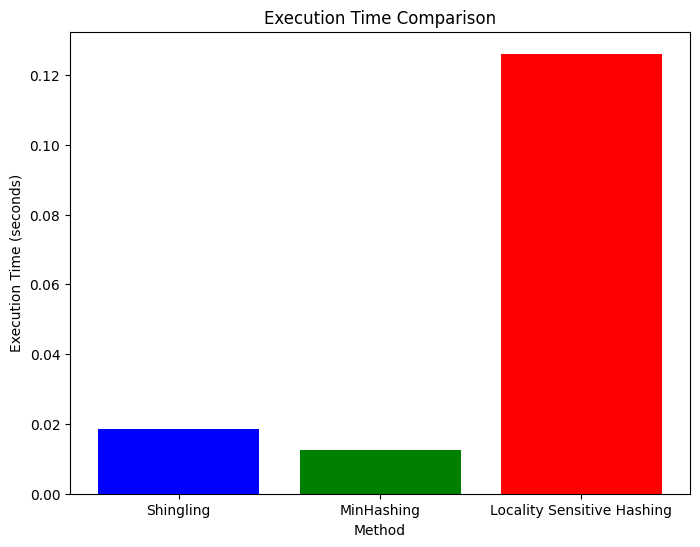

In [32]:
execution_times = [shingling_execution_time, minhashing_execution_time, lsh_execution_time]
methods = ['Shingling', 'MinHashing', 'Locality Sensitive Hashing']

# Bar plot for the execution times
plt.figure(figsize=(8, 6))
plt.bar(methods, execution_times, color=['blue', 'green', 'red'])

plt.xlabel('Method')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')

plt.show()


## Interpretation of Results

When using the shingling method, the algorithm correctly identified the similar documents (the ones where the Jaccard similarity was above the threshold) between all the similarities. We can verify this because we printed also the similarity of all documents.
We also noted a relatively low execution time for this step, which is reasonable given the small dataset (only 10 documents). For a larger dataset, we might expect a longer duration due to increased text processing and hashing.

When using the MinHashing method, the algorithm correctly identified the same documents as similar. We can see that the similarity values are a bit different (this time we are dealing with an estimation), but anyway above the threshold.
We noted a fast execution time, which could make sense since the number of hash functions used is small.

When using LSH, once again the results are correct. Here we noted that LSH took significantly more execution time. A possible reason is that it splits each MinHash signature into bands, and this step involves several transformations and multiple operations in Spark to create and group bands. Even though LSH is efficient in theory, Spark’s transformations over small datasets can lead to overheads.

Overall, we positively tested and evaluated our implementations with all the three methods.